In [150]:
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from itertools import islice
import string
from uptake_functions import *
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahathi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
features = pd.read_excel('data/all_uptakes.xlsx')
features

,conversation_id,text,seq.type,student.cefr.level,student.L1,id,participant,label,human_int,text0,...,prev_text_proc,cos_proc_across_pages,cos_proc_within_page,proc_LCS,proc_common_words,perc_dial1,perc_dial2,first_role,perTinS,perSinT
0,118,TEACHER:\n Hello <STUDENT>!\n\nSTUDENT:\n ...,"opening,",C2,Italian,22313,5ef3efcb420ab11a45a0b8a6,"['EXP INT 1', 'INT 0']",0,TEACHER:\n Hello <STUDENT>!\n==============...,...,NaN,0.486021,0.855612,0,0,0.000000,0.000000,teacher,0.000000,0.000000
1,118,TEACHER:\n Hi - welcome to the chat\n Ho...,", topic opening, , ,",C2,Italian,22314,5ef3efcb420ab11a45a0b8a6,"['EXP INT 2', 'INT 2']",2,TEACHER:\n Hi - welcome to the chat\n Ho...,...,hello student hi teacher,0.668713,0.568632,1,0,0.000000,0.000000,teacher,0.000000,0.000000
2,118,"TEACHER:\n Oh Austria, interesting!\n Al...",", , topic development",C2,Italian,22315,5ef3efcb420ab11a45a0b8a6,"['EXP INT 1', 'INT 1']",1,"TEACHER:\n Oh Austria, interesting!\n Al...",...,hi welcome chat you world thank you thank lett...,0.710058,0.475700,0,0,0.000000,0.000000,teacher,0.000000,0.000000
3,118,"TEACHER:\n I'm from Ukraine, but I've lived...",",",C2,Italian,22316,5ef3efcb420ab11a45a0b8a6,"['EXP INT 2', 'INT 3']",3,"TEACHER:\n I'm from Ukraine, but I've lived...",...,oh austria interesting pastry music yes nice p...,0.571614,0.694333,2,3,0.375000,0.125000,teacher,0.125000,0.375000
4,118,"TEACHER:\n Yes, I was an English teacher an...",", , , ,",C2,Italian,22317,5ef3efcb420ab11a45a0b8a6,"['EXP INT 3', 'INT 3']",3,"TEACHER:\n Yes, I was an English teacher an...",...,i m ukraine i ve lived uk last years speak ger...,0.779869,0.679965,1,3,0.115385,0.166667,teacher,0.166667,0.115385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19963,201,"STUDENT:\n Now\n\nTEACHER:\n Yes, absolu...",", scaffolding",B2,Mandarin Chinese,64431,5efd146921bf49159fe2d166,"['EXP INT 2', 'INT 2', 'The alternative is bet...",2,STUDENT:\n Now\n========Rate if this studen...,...,present simple maybe indications time yes some...,0.589082,0.473994,0,0,0.000000,0.000000,student,0.000000,0.000000
19964,201,STUDENT:\n or still doing something not fin...,", topic opening,",B2,Mandarin Chinese,64432,5efd146921bf49159fe2d166,"['EXP INT 2', 'INT 3', 'The alternative is wor...",3,STUDENT:\n or still doing something not fin...,...,yes absolutely now moment etc,0.552833,0.470137,0,0,0.000000,0.000000,student,0.000000,0.000000
19965,201,STUDENT:\n next month\n\nTEACHER:\n Ok! ...,NaN,B2,Mandarin Chinese,64433,5efd146921bf49159fe2d166,"['EXP INT 2', 'INT 2', 'The alternative is wor...",2,STUDENT:\n next month\n========Rate if this...,...,still something finish phd exam soon yes that ...,0.591994,0.600104,1,1,0.500000,0.125000,student,0.500000,0.125000
19966,201,STUDENT:\n OK.\n Thanks a lot.\n\nTEACHE...,", , , closing",B2,Mandarin Chinese,64434,5efd146921bf49159fe2d166,"['EXP INT 2', 'INT 2', 'The alternative is wor...",2,STUDENT:\n OK.\n Thanks a lot.\n========...,...,next month ok i ll prepare grammar material ne...,0.499714,0.630554,1,1,0.333333,0.142857,student,0.333333,0.142857


In [3]:
convokit = pd.read_excel('data/convokit_uptake1.xlsx')
convokit

,id,text,teacher_uptake_student,student_uptake_teacher
0,22313,TEACHER:\n Hello <STUDENT>! STUDENT:\n H...,NaN,0.999087
1,22314,TEACHER:\n Hi - welcome to the chat\n Ho...,0.998000,0.938766
2,22315,"TEACHER:\n Oh Austria, interesting!\n Al...",0.986824,0.627085
3,22316,"TEACHER:\n I'm from Ukraine, but I've lived...",0.997537,0.996571
4,22317,"TEACHER:\n Yes, I was an English teacher an...",0.991618,0.999184
...,...,...,...,...
6651,67110,STUDENT:\n let me think\n past simple! T...,0.693843,0.997308
6652,67111,STUDENT:\n because in recent year is presen...,0.998417,0.951334
6653,67112,STUDENT:\n yes.. I think I can understand i...,0.276067,0.774874
6654,67113,STUDENT:\n yes that is what I like to do TE...,0.747850,0.204560


In [4]:
features.columns

Index(['conversation_id', 'text', 'seq.type', 'student.cefr.level',
       'student.L1', 'id', 'participant', 'label', 'human_int', 'text0',
       'annotator_level', 'dial1', 'dial2', 'cos_within_page', 'Flag',
       'prev_text', 'cos_across_pages', 'dial1_proc', 'dial2_proc',
       'text_proc', 'prev_text_proc', 'cos_proc_across_pages',
       'cos_proc_within_page', 'proc_LCS', 'proc_common_words', 'perc_dial1',
       'perc_dial2', 'first_role', 'perTinS', 'perSinT'],
      dtype='object')

In [41]:
combined = features[['id','conversation_id', 'text','student.cefr.level', 'annotator_level', 'first_role','human_int']].merge(convokit.drop(columns=['text']), on='id', how='left', indicator=True)

In [42]:
def get_uptake_in_page(first_role, student_uptake_teacher, teacher_uptake_student):
    if first_role=='teacher':
        return "student_uptake_teacher"
    else:
        return "teacher_uptake_student"
    
def get_uptake_in_page1(first_role, student_uptake_teacher, teacher_uptake_student):
    if first_role=='teacher':
        return student_uptake_teacher
    else:
        return teacher_uptake_student

In [57]:
combined['uptake'] = combined.apply(lambda x: get_uptake_in_page(x.first_role, x.student_uptake_teacher, x.teacher_uptake_student), axis=1)
combined['uptake_val'] = combined.apply(lambda x: get_uptake_in_page1(x.first_role, x.student_uptake_teacher, x.teacher_uptake_student), axis=1)
combined['uptake_val'] = combined['uptake_val'].apply(lambda x: round(x,2))
combined.sort_values('id').head()

,id,conversation_id,text,student.cefr.level,annotator_level,first_role,human_int,teacher_uptake_student,student_uptake_teacher,_merge,uptake,uptake_val
0,22313,118,TEACHER:\n Hello <STUDENT>!\n\nSTUDENT:\n ...,C2,Unknown,teacher,0,NaN,0.999087,both,student_uptake_teacher,1.00
286,22313,118,TEACHER:\n Hello <STUDENT>!\n\nSTUDENT:\n ...,C2,Unknown,teacher,1,NaN,0.999087,both,student_uptake_teacher,1.00
572,22313,118,TEACHER:\n Hello <STUDENT>!\n\nSTUDENT:\n ...,C2,Unknown,teacher,0,NaN,0.999087,both,student_uptake_teacher,1.00
573,22314,118,TEACHER:\n Hi - welcome to the chat\n Ho...,C2,Unknown,teacher,2,0.998,0.938766,both,student_uptake_teacher,0.94
1,22314,118,TEACHER:\n Hi - welcome to the chat\n Ho...,C2,Unknown,teacher,2,0.998,0.938766,both,student_uptake_teacher,0.94


In [51]:
combined[combined['uptake_val'].isna()]['text'].values[:10]

array(["STUDENT:\n    yes!!\n\nTEACHER:\n    They _____ wearing ...'?",
       "STUDENT:\n    ok\n\nTEACHER:\n    In some countries people prefer renting their homes to buying them. What are the advantages and disadvantages of renting?\n    OK make sense? Give me a couple of main ideas just with basic keywords if you like...i'll give you a minute OK?",
       'STUDENT:\n    inconvenient\n\nTEACHER:\n    OK good!\n    So <STUDENT> ...getting verb tenses and getting nouns/verb/adjective forms right are two big things you can improve for a better score ok?',
       'STUDENT:\n    ok,thanks\n\nTEACHER:\n    Quick test coming up OK? Choose the right option for each sentence : We need silence/silent in the room please. It’s difficult to tell the difference/different between twins. Lung cancer is a common consequence/consequent of smoking.',
       'STUDENT:\n    silent/difference/consequence\n\nTEACHER:\n    THanks <STUDENT>...you need to change one of your answers! Which one?',
       "STUD

In [58]:
combined['uptake_val'].value_counts(dropna=False)

uptake_val
1.00    2466
NaN     2082
0.99    1356
0.98     510
0.97     462
        ... 
0.11      21
0.02      18
0.06      18
0.01       9
0.05       6
Name: count, Length: 100, dtype: int64

In [59]:
combined[['student.cefr.level', 'annotator_level']].value_counts()

student.cefr.level  annotator_level
B2                  Unknown            9280
                    C1                 2596
C2                  Unknown            1731
C1                  Unknown            1197
B2                  B2                 1142
B1                  Unknown            1000
C2                  C1                  971
B1                  C1                  396
B2                  C2                  369
C2                  B2                  268
C1                  C1                  258
                    B2                  150
B1                  B2                  131
C2                  C2                  128
                    A2                  112
B1                  C2                  101
B2                  A2                  101
B1                  A2                   37
Name: count, dtype: int64

In [60]:
combined[['human_int', 'uptake_val']]

,human_int,uptake_val
0,0,1.00
1,2,0.94
2,1,0.63
3,3,1.00
4,3,1.00
...,...,...
19963,2,NaN
19964,3,0.82
19965,2,0.91
19966,2,0.98


In [61]:
from sklearn.metrics import mean_squared_error

## PLOTS

In [3]:
uptakes = pd.read_excel('data/all_uptakes_final.xlsx')
uptakes

,id,conversation_id,text,seq.type,student.cefr.level,student.L1,participant,label,human_int,text0,...,LCS,common_words,first_role,perc_dial1,perc_dial2,perTinS,perSinT,text_proc,prev_text_proc,cos_proc_pages
0,45939,7,"TEACHER:\n Hi there <STUDENT>, all OK?\n\nS...",['opening'],C1,Spanish,5d2b153afa24ba00173e8ee0,"['EXP INT 1', 'INT 1']",1,"TEACHER:\n Hi there <STUDENT>, all OK?\n===...",...,1,1,teacher,0.333333,0.500000,0.500000,0.333333,hi student ok hi teacher you,NaN,0.000000
1,22314,118,TEACHER:\n Hi - welcome to the chat\n Ho...,['topic opening'],C2,Italian,5ef3efcb420ab11a45a0b8a6,"['EXP INT 2', 'INT 2']",2,TEACHER:\n Hi - welcome to the chat\n Ho...,...,1,0,teacher,0.000000,0.000000,0.000000,0.000000,hi welcome chat you world thank you thank lett...,hello student hi teacher,0.668713
2,22315,118,"TEACHER:\n Oh Austria, interesting!\n Al...",['topic development'],C2,Italian,5ef3efcb420ab11a45a0b8a6,"['EXP INT 1', 'INT 1']",1,"TEACHER:\n Oh Austria, interesting!\n Al...",...,0,0,teacher,0.000000,0.000000,0.000000,0.000000,oh austria interesting pastry music yes nice p...,hi welcome chat you world thank you thank lett...,0.710058
3,22316,118,"TEACHER:\n I'm from Ukraine, but I've lived...",[],C2,Italian,5ef3efcb420ab11a45a0b8a6,"['EXP INT 2', 'INT 3']",3,"TEACHER:\n I'm from Ukraine, but I've lived...",...,2,3,teacher,0.300000,0.125000,0.125000,0.300000,i m ukraine i ve lived uk last years speak ger...,oh austria interesting pastry music yes nice p...,0.571614
4,22317,118,"TEACHER:\n Yes, I was an English teacher an...",[],C2,Italian,5ef3efcb420ab11a45a0b8a6,"['EXP INT 3', 'INT 3']",3,"TEACHER:\n Yes, I was an English teacher an...",...,1,3,teacher,0.074074,0.111111,0.111111,0.074074,yes english teacher cambridge examiner back uk...,i m ukraine i ve lived uk last years speak ger...,0.779869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19963,56389,258,"TEACHER:\n Yes, absolutely!\n\nSTUDENT:\n ...",[],C2,Italian,5f7d002d141e4e1c0e84e98e,"['EXP INT 0', 'INT 1', 'The alternative is wor...",1,"TEACHER:\n Yes, absolutely!\n========Rate i...",...,0,0,teacher,0.000000,0.000000,0.000000,0.000000,yes absolutely 13 59 laptop,ooh we re time maybe money institutions,0.379967
19964,56389,258,"TEACHER:\n Yes, absolutely!\n\nSTUDENT:\n ...",[],C2,Italian,58c62eac444ade00010231a9,"['EXP INT 0', 'INT 0', 'The alternative is wor...",0,"TEACHER:\n Yes, absolutely!\n========Rate i...",...,0,0,teacher,0.000000,0.000000,0.000000,0.000000,yes absolutely 13 59 laptop,ooh we re time maybe money institutions,0.379967
19965,56390,258,"TEACHER:\n Loan is more formal!\n Right,...",[],C2,Italian,5f770f1691d3f91d768299f3,"['EXP INT 4', 'INT 4', 'The alternative is wor...",4,"TEACHER:\n Loan is more formal!\n Right,...",...,1,2,teacher,0.136364,0.187500,0.187500,0.136364,loan formal right thank much participating pro...,yes absolutely 13 59 laptop,0.455469
19966,56390,258,"TEACHER:\n Loan is more formal!\n Right,...",[],C2,Italian,5f7d002d141e4e1c0e84e98e,"['EXP INT 0', 'INT 1', 'The alternative is wor...",1,"TEACHER:\n Loan is more formal!\n Right,...",...,1,2,teacher,0.136364,0.187500,0.187500,0.136364,loan formal right thank much participating pro...,yes absolutely 13 59 laptop,0.455469


In [4]:
uptakes.columns

Index(['id', 'conversation_id', 'text', 'seq.type', 'student.cefr.level',
       'student.L1', 'participant', 'label', 'human_int', 'text0',
       'annotator_level', 'dial1', 'dial2', 'cos_within_page', 'Flag',
       'prev_text', 'cos_pages', 'dial1_proc', 'dial2_proc',
       'cos_proc_within_page', 'LCS', 'common_words', 'first_role',
       'perc_dial1', 'perc_dial2', 'perTinS', 'perSinT', 'text_proc',
       'prev_text_proc', 'cos_proc_pages'],
      dtype='object')

In [6]:
df = uptakes[['human_int', 'annotator_level', 'cos_proc_within_page','cos_proc_pages', 'cos_within_page','cos_pages','LCS', 'perTinS', 'perSinT']]
df

,human_int,annotator_level,cos_proc_within_page,cos_proc_pages,cos_within_page,cos_pages,LCS,perTinS,perSinT
0,1,Unknown,0.855612,0.000000,0.940960,0.000000,1,0.500000,0.333333
1,2,Unknown,0.568632,0.668713,0.676597,0.743557,1,0.000000,0.000000
2,1,Unknown,0.475700,0.710058,0.659000,0.844195,0,0.000000,0.000000
3,3,Unknown,0.694333,0.571614,0.754039,0.730307,2,0.125000,0.300000
4,3,Unknown,0.679965,0.779869,0.707947,0.865192,1,0.111111,0.074074
...,...,...,...,...,...,...,...,...,...
19963,1,B2,0.352811,0.379967,0.454114,0.692508,0,0.000000,0.000000
19964,0,B2,0.352811,0.379967,0.454114,0.692508,0,0.000000,0.000000
19965,4,C1,0.697254,0.455469,0.723179,0.648303,1,0.187500,0.136364
19966,1,B2,0.697254,0.455469,0.723179,0.648303,1,0.187500,0.136364


In [7]:
int_col = 'human_int'

high_int = df[df[int_col] > 3]
low_int = df[df[int_col] < 2]
mid_int = df[(df[int_col] >= 2) & (df[int_col] <= 3)]

# Assign intensity level
high_int['int_level'] = 'High'
low_int['int_level'] = 'Low'
mid_int['int_level'] = 'Mid'

# Concatenate the dataframes
combined_data = pd.concat([high_int, low_int, mid_int])
combined_data

,human_int,annotator_level,cos_proc_within_page,cos_proc_pages,cos_within_page,cos_pages,LCS,perTinS,perSinT,int_level
105,4,C1,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,High
287,4,Unknown,0.568632,0.668713,0.676597,0.743557,1,0.000000,0.000000,High
289,4,Unknown,0.694333,0.571614,0.754039,0.730307,2,0.125000,0.300000,High
290,4,Unknown,0.679965,0.779869,0.707947,0.865192,1,0.111111,0.074074,High
292,4,Unknown,0.696072,0.791378,0.725196,0.748642,1,0.133333,0.142857,High
...,...,...,...,...,...,...,...,...,...,...
19950,3,C1,0.484199,0.579204,0.643053,0.742184,0,0.000000,0.000000,Mid
19952,2,B2,0.484199,0.579204,0.643053,0.742184,0,0.000000,0.000000,Mid
19956,2,C1,0.643408,0.753728,0.720573,0.882321,1,0.111111,0.090909,Mid
19959,2,C1,0.450211,0.606922,0.487348,0.721032,0,0.000000,0.000000,Mid


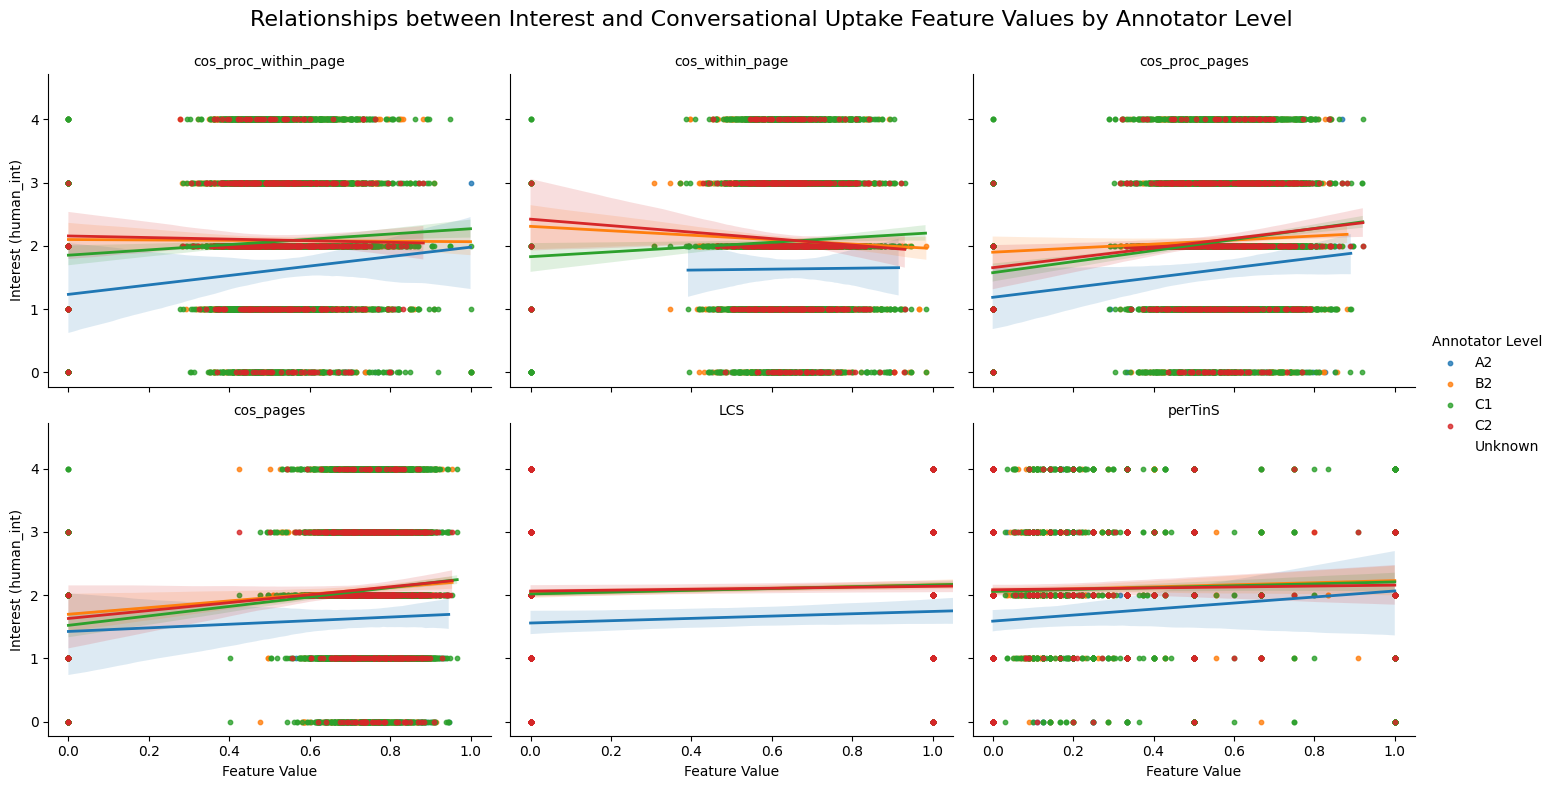

In [39]:
without_unknown = combined_data[combined_data['annotator_level']!="Unknown"]

# Melt the dataframe to make it long-form for faceted plotting
df_melted = pd.melt(without_unknown, id_vars=['human_int', 'annotator_level'], 
                    value_vars=['cos_proc_within_page', 'cos_within_page','cos_proc_pages','cos_pages', 'LCS', 'perTinS'], 
                    var_name='Feature', value_name='Value')

# Set up a FacetGrid for different features, faceted by annotator_level
g = sns.FacetGrid(df_melted, col='Feature', hue='annotator_level',  hue_order=hue_order, col_wrap=3, height=4, aspect=1.2)

# Create a scatterplot with a regression line for each feature
g = g.map(sns.regplot, 'Value', 'human_int', scatter_kws={'s': 10}, line_kws={'lw': 2})

# Customize the x-axis limits for each feature based on its range
for ax, feature in zip(g.axes.flat, df_melted['Feature'].unique()):
    feature_data = df_melted[df_melted['Feature'] == feature]
    ax.set_xlim([feature_data['Value'].min() - 0.05, feature_data['Value'].max() + 0.05])

# Customize the plot appearance
g.add_legend(title='Annotator Level')
g.set_axis_labels("Feature Value", "Interest (human_int)")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationships between Interest and Conversational Uptake Feature Values by Annotator Level', fontsize=16)

# Show the plot
plt.show()

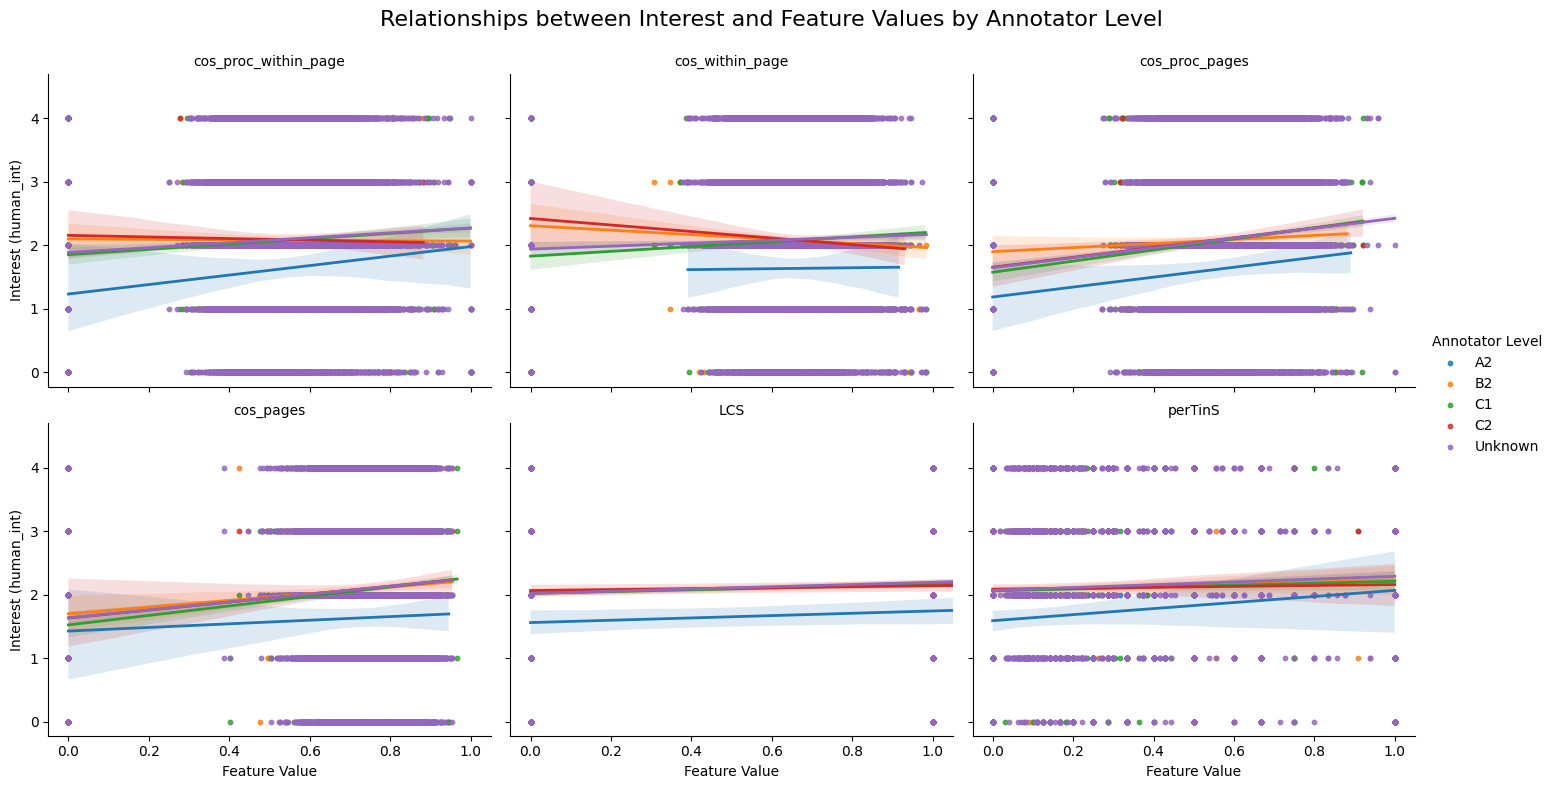

In [30]:


# Melt the dataframe to make it long-form for faceted plotting
df_melted = pd.melt(combined_data, id_vars=['human_int', 'annotator_level'], 
                    value_vars=['cos_proc_within_page', 'cos_within_page','cos_proc_pages','cos_pages', 'LCS', 'perTinS'], 
                    var_name='Feature', value_name='Value')

# Set up a FacetGrid for different features, faceted by annotator_level
g = sns.FacetGrid(df_melted, col='Feature', hue='annotator_level',  hue_order=hue_order, col_wrap=3, height=4, aspect=1.2)

# Create a scatterplot with a regression line for each feature
g = g.map(sns.regplot, 'Value', 'human_int', scatter_kws={'s': 10}, line_kws={'lw': 2})

# Customize the x-axis limits for each feature based on its range
for ax, feature in zip(g.axes.flat, df_melted['Feature'].unique()):
    feature_data = df_melted[df_melted['Feature'] == feature]
    ax.set_xlim([feature_data['Value'].min() - 0.05, feature_data['Value'].max() + 0.05])

# Customize the plot appearance
g.add_legend(title='Annotator Level')
g.set_axis_labels("Feature Value", "Interest (human_int)")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationships between Interest and Feature Values by Annotator Level', fontsize=16)

# Show the plot
plt.show()

Text(0.5, 0.98, 'Relationships between Interaction Level and Feature Values by Annotator Level')

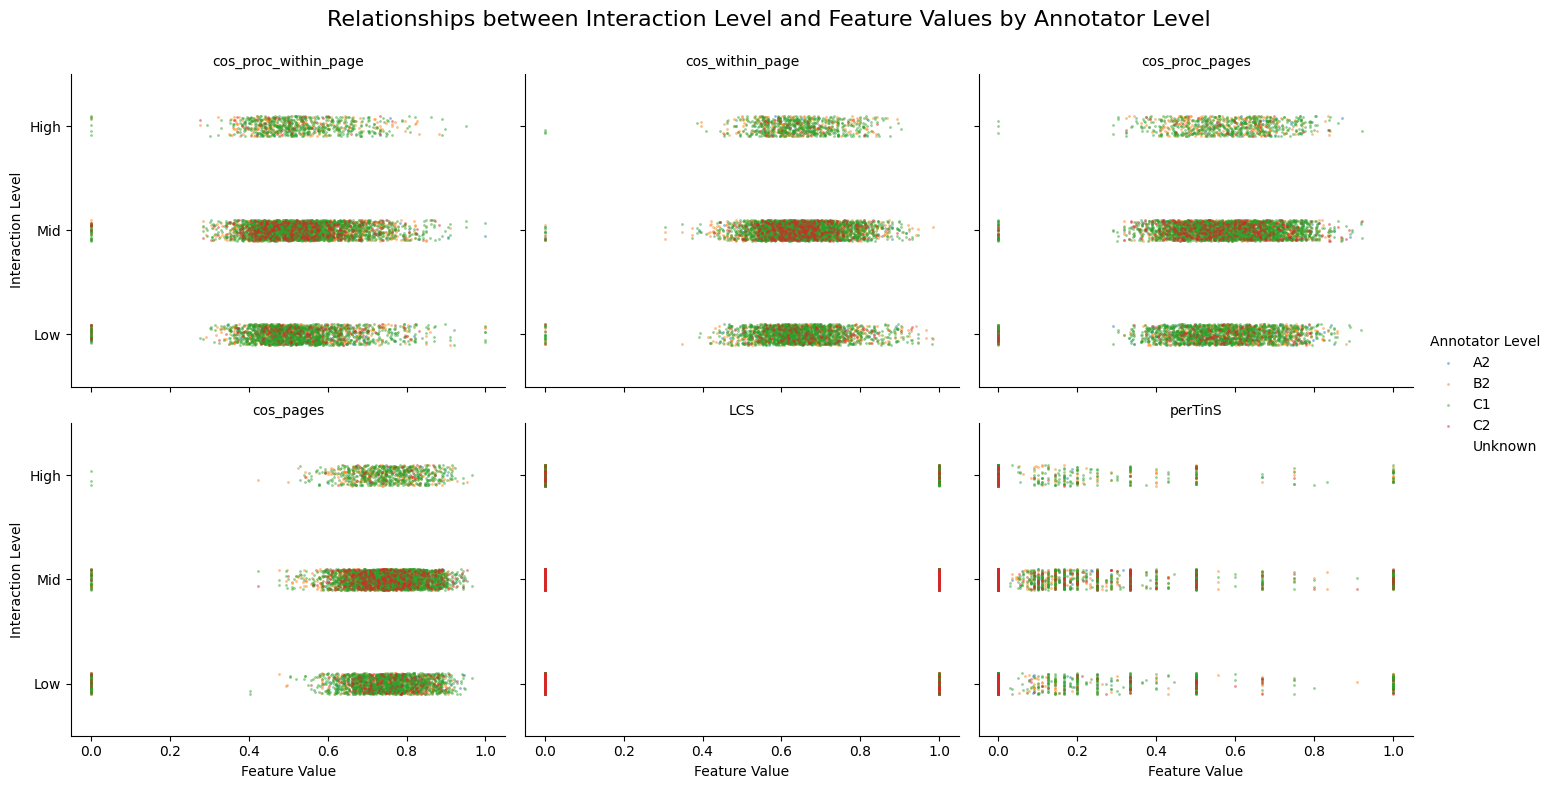

In [38]:
# Melt the dataframe to make it long-form for faceted plotting
df_melted = pd.melt(without_unknown, id_vars=['int_level', 'annotator_level'], 
                    value_vars=['cos_proc_within_page', 'cos_within_page','cos_proc_pages','cos_pages', 'LCS', 'perTinS'], 
                    var_name='Feature', value_name='Value')

# Set up a FacetGrid for different features, faceted by annotator_level
g = sns.FacetGrid(df_melted, col='Feature', hue='annotator_level', hue_order=hue_order, col_wrap=3, height=4, aspect=1.2)

# Create a scatterplot (stripplot) for each feature, showing points categorized by int_level
g = g.map(sns.stripplot, 'Value', 'int_level', order=int_level_order,jitter=True, size=2, dodge=True, alpha=0.5)

# Customize the x-axis limits for each feature based on its range
for ax, feature in zip(g.axes.flat, df_melted['Feature'].unique()):
    feature_data = df_melted[df_melted['Feature'] == feature]
    ax.set_xlim([feature_data['Value'].min() - 0.05, feature_data['Value'].max() + 0.05])

# Customize the plot appearance
g.add_legend(title='Annotator Level')
g.set_axis_labels("Feature Value", "Interaction Level")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationships between Interaction Level and Feature Values by Annotator Level', fontsize=16)


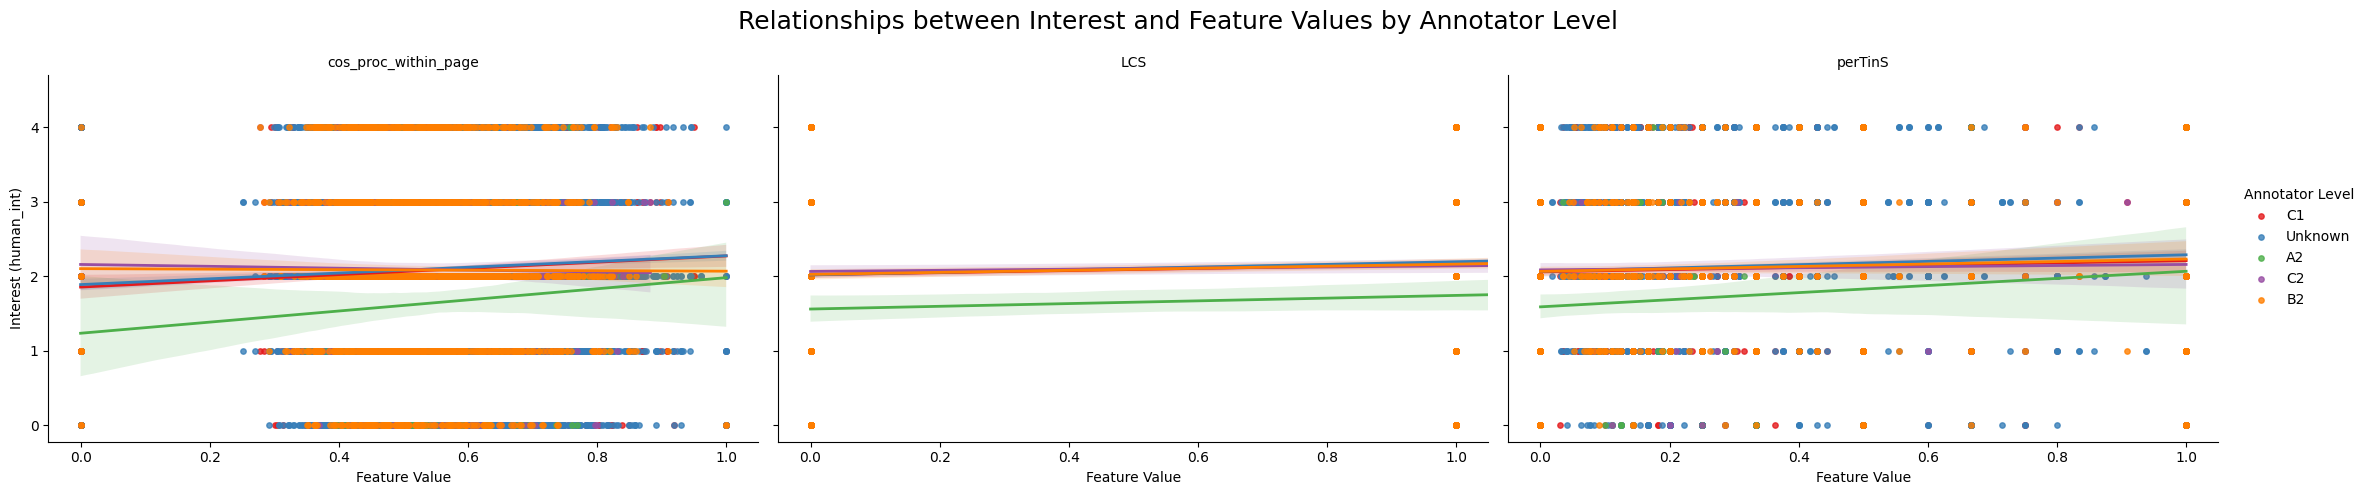

In [28]:
# Define the color palette for annotator levels
palette = sns.color_palette("Set1", 5)  # You can choose a different palette or adjust as needed

# Melt the dataframe to make it long-form for faceted plotting
df_melted = pd.melt(combined_data, id_vars=['human_int', 'annotator_level'], 
                    value_vars=['cos_proc_within_page', 'LCS', 'perTinS'], 
                    var_name='Feature', value_name='Value')

# Set up a FacetGrid for different features
g = sns.FacetGrid(df_melted, col='Feature', hue='annotator_level', order=int_level_order,palette=palette, col_wrap=3, height=5, aspect=1.5)

# Create a scatterplot with a regression line for each feature, adding confidence intervals
g = g.map(sns.regplot, 'Value', 'human_int', scatter_kws={'s': 15}, line_kws={'lw': 2}, ci=95)

# Customize the x-axis limits for each feature based on its range
for ax, feature in zip(g.axes.flat, df_melted['Feature'].unique()):
    feature_data = df_melted[df_melted['Feature'] == feature]
    ax.set_xlim([feature_data['Value'].min() - 0.05, feature_data['Value'].max() + 0.05])

# Add the legend and titles
g.add_legend(title='Annotator Level', adjust_subtitles=True)
g.set_axis_labels("Feature Value", "Interest (human_int)")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.85)

# Update the main title
g.fig.suptitle('Relationships between Interest and Feature Values by Annotator Level', fontsize=18)

# Show the plot
plt.show()

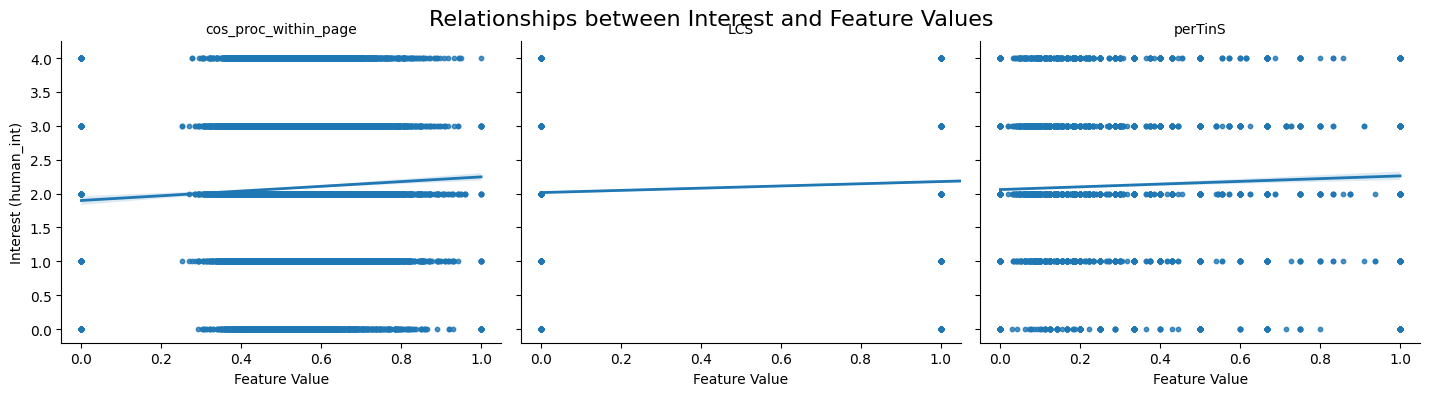

In [27]:


# Melt the dataframe to make it long-form for faceted plotting
df_melted = pd.melt(combined_data, id_vars=['human_int', ], 
                    value_vars=['cos_proc_within_page', 'LCS', 'perTinS'], 
                    var_name='Feature', value_name='Value')

# Set up a FacetGrid for different features, faceted by annotator_level
g = sns.FacetGrid(df_melted, col='Feature', col_wrap=3, height=4, aspect=1.2)

# Create a scatterplot with a regression line for each feature
g = g.map(sns.regplot, 'Value', 'human_int', scatter_kws={'s': 10}, line_kws={'lw': 2})

# Customize the x-axis limits for each feature based on its range
for ax, feature in zip(g.axes.flat, df_melted['Feature'].unique()):
    feature_data = df_melted[df_melted['Feature'] == feature]
    ax.set_xlim([feature_data['Value'].min() - 0.05, feature_data['Value'].max() + 0.05])

# Customize the plot appearance

g.set_axis_labels("Feature Value", "Interest (human_int)")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationships between Interest and Feature Values ', fontsize=16)

# Show the plot
plt.show()

0.10104464851511978
0.11209648817426163
0.10358555307921395
0.10325895472771406
0.10657790489521678
1.0


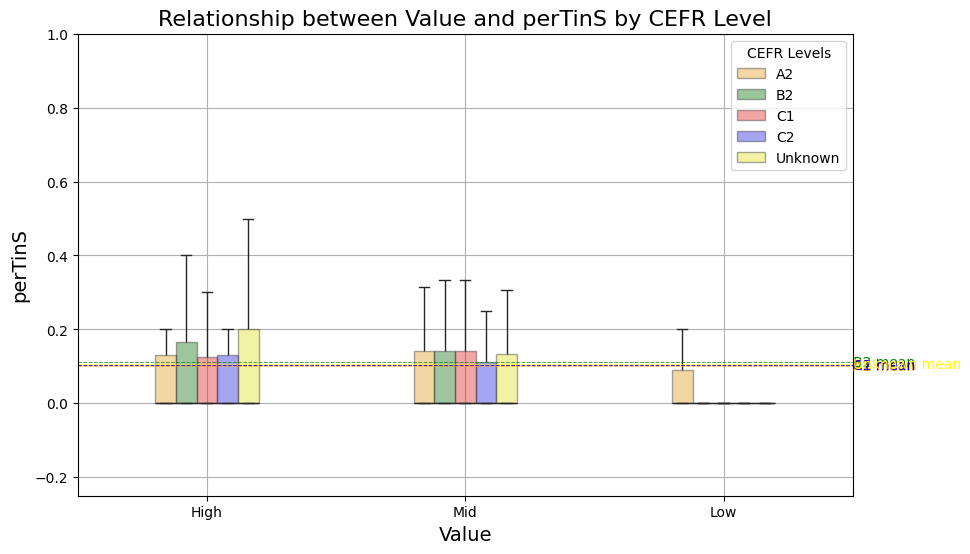

In [19]:
# Set up colors and markers for different CEFR levels
colors = {'C1': 'red', 'B2': 'green', 'C2': 'blue', 'A2': 'orange', 'Unknown': 'yellow'}

# Define hue order for CEFR levels and interaction levels
hue_order = ['A2', 'B2', 'C1', 'C2', 'Unknown']
int_level_order = ['High', 'Mid', 'Low']

# Calculate the average LCS values for each CEFR level to add a horizontal line
average_gis_by_cefr = combined_data.groupby('annotator_level')['perTinS'].mean()

# Create the figure
plt.figure(figsize=(10, 6))

# Plot boxplots for each value grouped by CEFR levels, with colors corresponding to CEFR levels
g = sns.boxplot(x='int_level', y='perTinS', hue='annotator_level', data=combined_data, palette=colors, showfliers=False, 
                width=0.4, boxprops=dict(alpha=0.4), hue_order=hue_order, order=int_level_order)

# Plot dotted lines for each CEFR level and label them
for level in hue_order:
    plt.axhline(y=average_gis_by_cefr[level], color=colors[level], linestyle='--', alpha=0.7, linewidth=0.7)
    # Label each line with the CEFR level
    plt.text(x=2.5, y=average_gis_by_cefr[level], s=f'{level} mean', color=colors[level], va='center', fontsize=10)
    print(average_gis_by_cefr[level])

# Customize plot
plt.title('Relationship between Value and perTinS by CEFR Level', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('perTinS', fontsize=14)

# Adjust y-axis limits if needed (optional, adjust based on your data)
plt.ylim([0-0.25, max(combined_data['perTinS']) ])

# Add a grid for better readability
plt.grid(True)

# Adjust the legend to remove duplicated labels (optional)
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[:len(hue_order)], labels[:len(hue_order)], title="CEFR Levels", loc='upper right')

# Show the plot
plt.show()


In [60]:
all_llms = pd.read_excel('data/combined_human_individual_all_llm_ratings.xlsx')
all_llms

,text,conversation_id,id,human_int_mean,human_int_var,58c62eac444ade00010231a9,59b536d60516f6000197c3f9,5ab15ab4c42b630001cd36fb,5ad63c167f70c10001904bc5,5b830542b0d72600018dc280,...,mix_int,mis7_int,gpt4_int,gpt4o_int,7b_int,13b_int,7bnonchat_int,13bnonchat_int,llama3_chat_int,llama3_nonchat_int
0,"teacher: hi there <student>, all ok? student:...",7,45939,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,3,3.0,2.0,1,1.0,4.0,0,2,4,2.0
1,"teacher: yeah i'm good thanks, just been for a...",7,45940,1.333333,0.333333,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,2,3.0,4.0,1,2,3,0.0
2,teacher: yeah? what did you do? i'll come back...,7,45941,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,2.0,3.0,3,2,4,1.0
3,teacher: ok i see ...too bad about the running...,7,45942,2.666667,0.333333,NaN,NaN,NaN,NaN,NaN,...,3,4.0,3.0,4,3.0,4.0,3,4,3,3.0
4,teacher: yes i realise it's not easy really! i...,7,45943,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,2,4.0,4.0,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,teacher: but 'to loan' means 'to lend' studen...,258,56386,1.000000,0.000000,1.0,NaN,NaN,NaN,NaN,...,2,2.0,2.0,1,4.0,3.0,2,1,2,4.0
6652,"teacher: banks loan money yes, exactly, it wou...",258,56387,1.333333,0.333333,1.0,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,3.0,2.0,3,1,3,3.0
6653,"teacher: ooh, we're out of time! student: or ...",258,56388,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,...,2,0.0,2.0,2,4.0,3.0,3,0,1,2.0
6654,"teacher: yes, absolutely! student: 13:59 on m...",258,56389,0.666667,0.333333,0.0,NaN,NaN,NaN,NaN,...,1,0.0,2.0,1,4.0,NaN,3,2,0,3.0


In [117]:
llama_other = pd.read_excel('data/all_llms_human.xlsx')
llama_other[['conversation_id', 'id', 'new_13bchat', 'new_7bchat']]

,conversation_id,id,new_13bchat,new_7bchat
0,7,45939,2.0,3.0
1,7,45940,2.0,3.0
2,7,45941,2.0,3.0
3,7,45942,3.0,3.0
4,7,45943,2.0,3.0
...,...,...,...,...
6651,258,56386,2.0,3.0
6652,258,56387,2.0,3.0
6653,258,56388,2.0,3.0
6654,258,56389,2.0,3.0


In [121]:
all_llms = all_llms.merge(llama_other[['conversation_id', 'id', 'new_13bchat', 'new_7bchat']], on=['conversation_id', 'id'])

In [126]:

custom_titles = [
     'LLama2 7b non-chat', 'LLama2 13b non-chat', 'LLama3 8b non-chat',
    'Llama2 7B chat (IB Prompt)', 'Llama2 13B chat(IB Prompt)' , 
    'Llama2 7B chat (CB Prompt)', 'Llama2 13B chat(CB Prompt)' ,
    'Llama3 8B chat', 'GPT-4', 'GPT-4o', 'Mistral 7B non-chat', 'Mistral 7B instruct', 'Mixtral 8x7B instruct','Averaged Human'
]

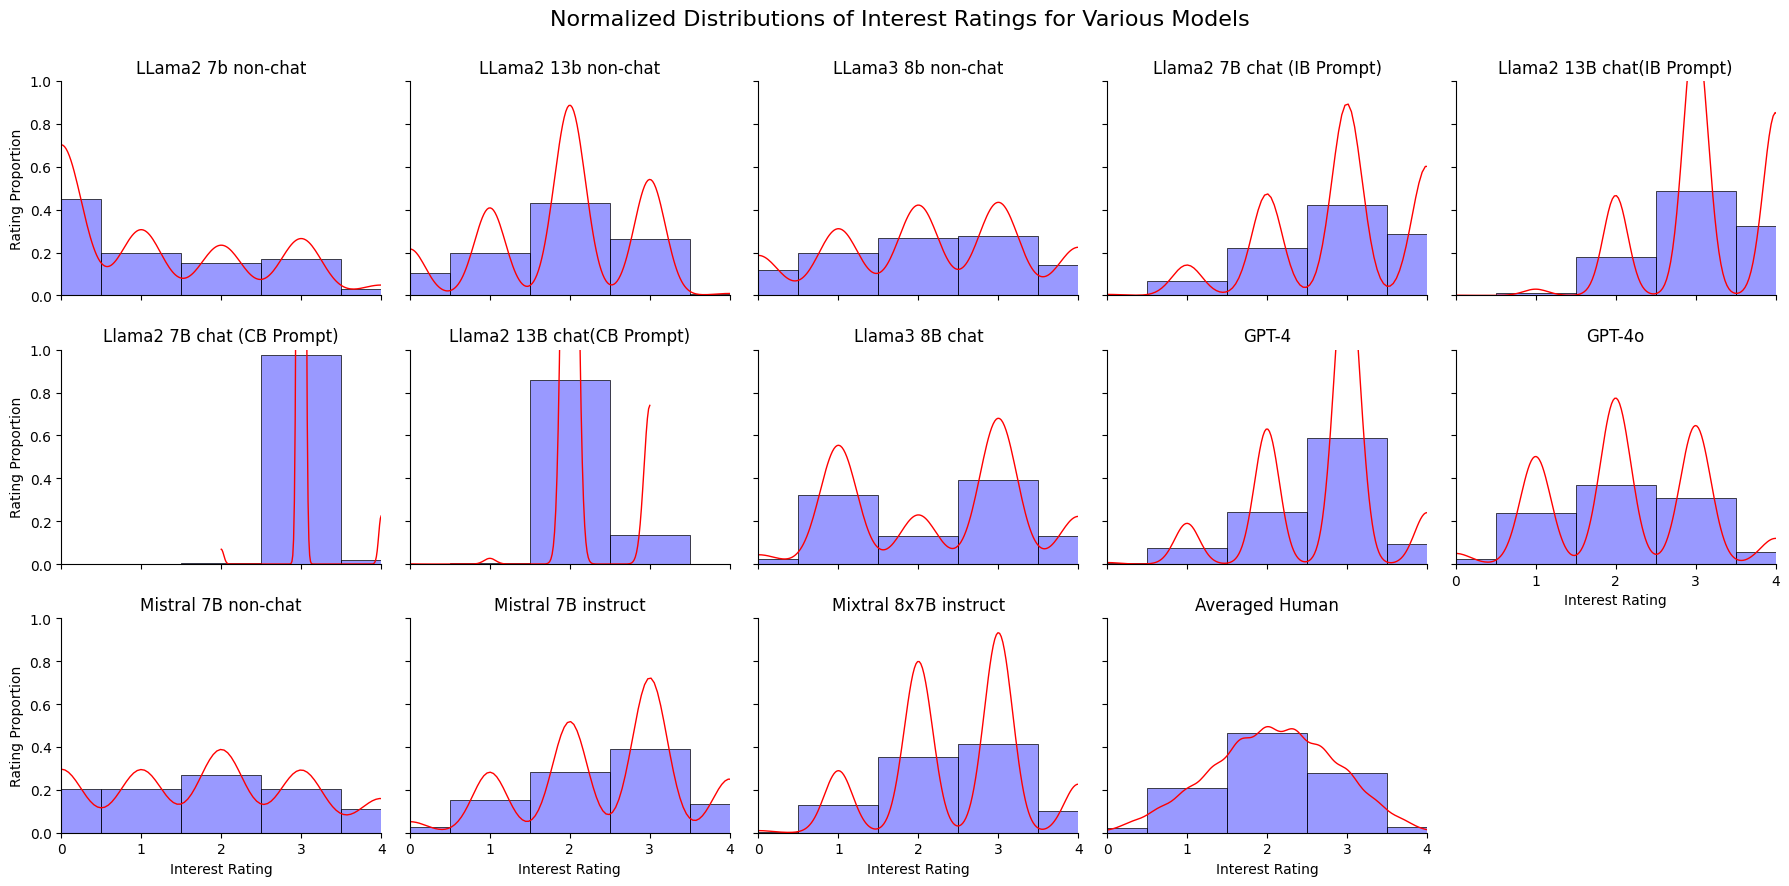

In [143]:
# Melt the dataframe to make it long-form for faceted plotting
df_melted = pd.melt(all_llms, value_vars=['7bnonchat_int', '13bnonchat_int', 'llama3_nonchat_int',
                                          '7b_int', '13b_int','new_7bchat','new_13bchat','llama3_chat_int', 'gpt4_int', 'gpt4o_int', 'mis_nonchat_int',  'mis7_int','mix_int','human_int_mean'],
                    var_name='Model', value_name='Value')

# Set up a FacetGrid for the distributions
g = sns.FacetGrid(df_melted, col='Model', col_wrap=5, height=3, aspect=1.2)

# Plot histograms with kde=False for normalization, and then separately plot kde
g = g.map(sns.histplot, 'Value', bins=20, color='blue', linewidth=0.5, alpha=0.4, stat="density", kde=False, discrete=True)
g = g.map(sns.kdeplot, 'Value', color='red', linewidth=1,common_norm=True,  cut=0, thresh=[0,1], bw_adjust=1.2)

# Customize the plot appearance and use the custom titles
for ax, title in zip(g.axes.flat, custom_titles):
    ax.set_title(title)

# # Customize the plot appearance
# g.set_titles("{col_name}")
g.set_axis_labels("Interest Rating", "Rating Proportion")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Normalized Distributions of Interest Ratings for Various Models', fontsize=16)

# Set x-axis limits to 0-4
for ax in g.axes.flat:
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 1)

# Show the plot
plt.show()

In [98]:
uptakes[['id', 'conversation_id', 'human_int', 'annotator_level']]

,id,conversation_id,human_int,annotator_level
0,45939,7,1,Unknown
1,22314,118,2,Unknown
2,22315,118,1,Unknown
3,22316,118,3,Unknown
4,22317,118,3,Unknown
...,...,...,...,...
19963,56389,258,1,B2
19964,56389,258,0,B2
19965,56390,258,4,C1
19966,56390,258,1,B2


In [91]:
comp = pd.read_excel('data/readbility_metrics.xlsx')
comp

,proc_text,conversation_id,id,int_mean,int_var,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,spache_readability,syllable_count,lexicon_count,difficult_words,gunning_fog,linsear_write_formula,mcalpine_eflaw,text_standard
0,"hi <teacher>, how are you? yeah i'm good th...",7,53285,3.000000,1.000000,98.92,1.0,6.0,1.74,1.9,7.11,2.75,30,25,3,4.12,2.375000,9.5,2
1,yeah well my daughter started doing it and ha...,7,45947,1.666667,0.333333,89.79,4.5,6.4,3.70,4.6,6.11,3.37,57,46,2,6.12,7.166667,24.0,5
2,yeah? in the uk too i'd say....there are lots...,7,45955,1.666667,0.333333,82.65,5.2,9.5,4.28,4.8,7.71,3.43,71,56,4,7.74,7.375000,21.5,8
3,yeah? what did you do? i'll come back on the ...,7,45941,2.000000,0.000000,83.05,5.1,8.1,4.34,4.1,6.92,3.79,139,109,13,6.91,5.875000,20.8,6
4,great but not 'as a team' just for yourself...,7,53297,2.000000,4.000000,69.28,6.2,0.0,5.83,5.1,7.16,3.14,31,21,2,6.10,5.750000,15.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,"but then, if you have some exercises or inter...",258,38329,2.333333,1.333333,63.22,10.6,11.7,7.14,11.5,7.58,5.54,139,99,14,12.75,14.750000,36.8,8
6652,my guess is that in italian 'borrow' and 'len...,258,56381,1.666667,1.333333,75.24,8.1,9.7,7.08,10.0,7.65,4.92,83,64,8,9.15,12.166667,30.0,10
6653,nearly! had ___ up in another time they are...,258,56382,1.666667,1.333333,88.06,5.2,0.0,3.25,5.2,6.80,3.74,41,34,2,7.98,8.500000,26.5,6
6654,maybe i should start by writing a topic sente...,258,38323,2.333333,2.333333,74.19,6.4,9.4,8.87,8.7,8.62,4.29,98,70,12,8.46,7.400000,19.2,9


In [101]:
merged_comp = uptakes[['id', 'conversation_id', 'human_int', 'annotator_level']].merge(comp, on=['conversation_id', 'id'], how='left')
merged_comp

,id,conversation_id,human_int,annotator_level,proc_text,int_mean,int_var,flesch_reading_ease,flesch_kincaid_grade,smog_index,...,automated_readability_index,dale_chall_readability_score,spache_readability,syllable_count,lexicon_count,difficult_words,gunning_fog,linsear_write_formula,mcalpine_eflaw,text_standard
0,45939,7,1,Unknown,"hi there <student>, all ok? hi <teacher>, h...",1.000000,1.000000,100.24,0.5,0.0,...,2.3,8.62,2.40,12,10,1,2.00,1.500000,8.5,2
1,22314,118,2,Unknown,hi - welcome to the chat how are you? and whe...,2.666667,1.333333,104.44,1.0,3.1,...,1.1,5.82,2.44,62,55,2,3.68,3.666667,14.2,4
2,22315,118,1,Unknown,"oh austria, interesting! all the pastry and m...",1.666667,1.333333,89.04,2.8,6.4,...,1.1,6.08,2.67,29,23,2,3.08,3.500000,13.0,3
3,22316,118,3,Unknown,"i'm from ukraine, but i've lived in the uk fo...",2.666667,2.333333,93.64,3.1,3.1,...,3.7,6.95,3.33,84,69,7,4.60,4.750000,16.8,5
4,22317,118,3,Unknown,"yes, i was an english teacher and cambridge e...",2.666667,2.333333,82.34,5.3,7.2,...,7.2,6.92,3.96,115,86,11,6.65,6.833333,20.5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19963,56389,258,1,B2,"yes, absolutely! 13:59 on my laptop i a...",0.666667,0.333333,66.74,7.2,0.0,...,4.6,10.35,4.66,19,13,3,8.28,6.500000,20.0,7
19964,56389,258,0,B2,"yes, absolutely! 13:59 on my laptop i a...",0.666667,0.333333,66.74,7.2,0.0,...,4.6,10.35,4.66,19,13,3,8.28,6.500000,20.0,7
19965,56390,258,4,C1,"loan is more formal! right, thank you very mu...",2.333333,2.333333,94.56,2.7,6.4,...,3.8,6.03,2.87,155,127,8,5.50,6.714286,15.5,6
19966,56390,258,1,B2,"loan is more formal! right, thank you very mu...",2.333333,2.333333,94.56,2.7,6.4,...,3.8,6.03,2.87,155,127,8,5.50,6.714286,15.5,6


In [102]:
print(merged_comp.head())

      id  conversation_id  human_int annotator_level  \
0  45939                7          1         Unknown   
1  22314              118          2         Unknown   
2  22315              118          1         Unknown   
3  22316              118          3         Unknown   
4  22317              118          3         Unknown   

                                           proc_text  int_mean   int_var  \
0   hi there <student>, all ok?   hi <teacher>, h...  1.000000  1.000000   
1   hi - welcome to the chat how are you? and whe...  2.666667  1.333333   
2   oh austria, interesting! all the pastry and m...  1.666667  1.333333   
3   i'm from ukraine, but i've lived in the uk fo...  2.666667  2.333333   
4   yes, i was an english teacher and cambridge e...  2.666667  2.333333   

   flesch_reading_ease  flesch_kincaid_grade  smog_index  ...  \
0               100.24                   0.5         0.0  ...   
1               104.44                   1.0         3.1  ...   
2          

In [103]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

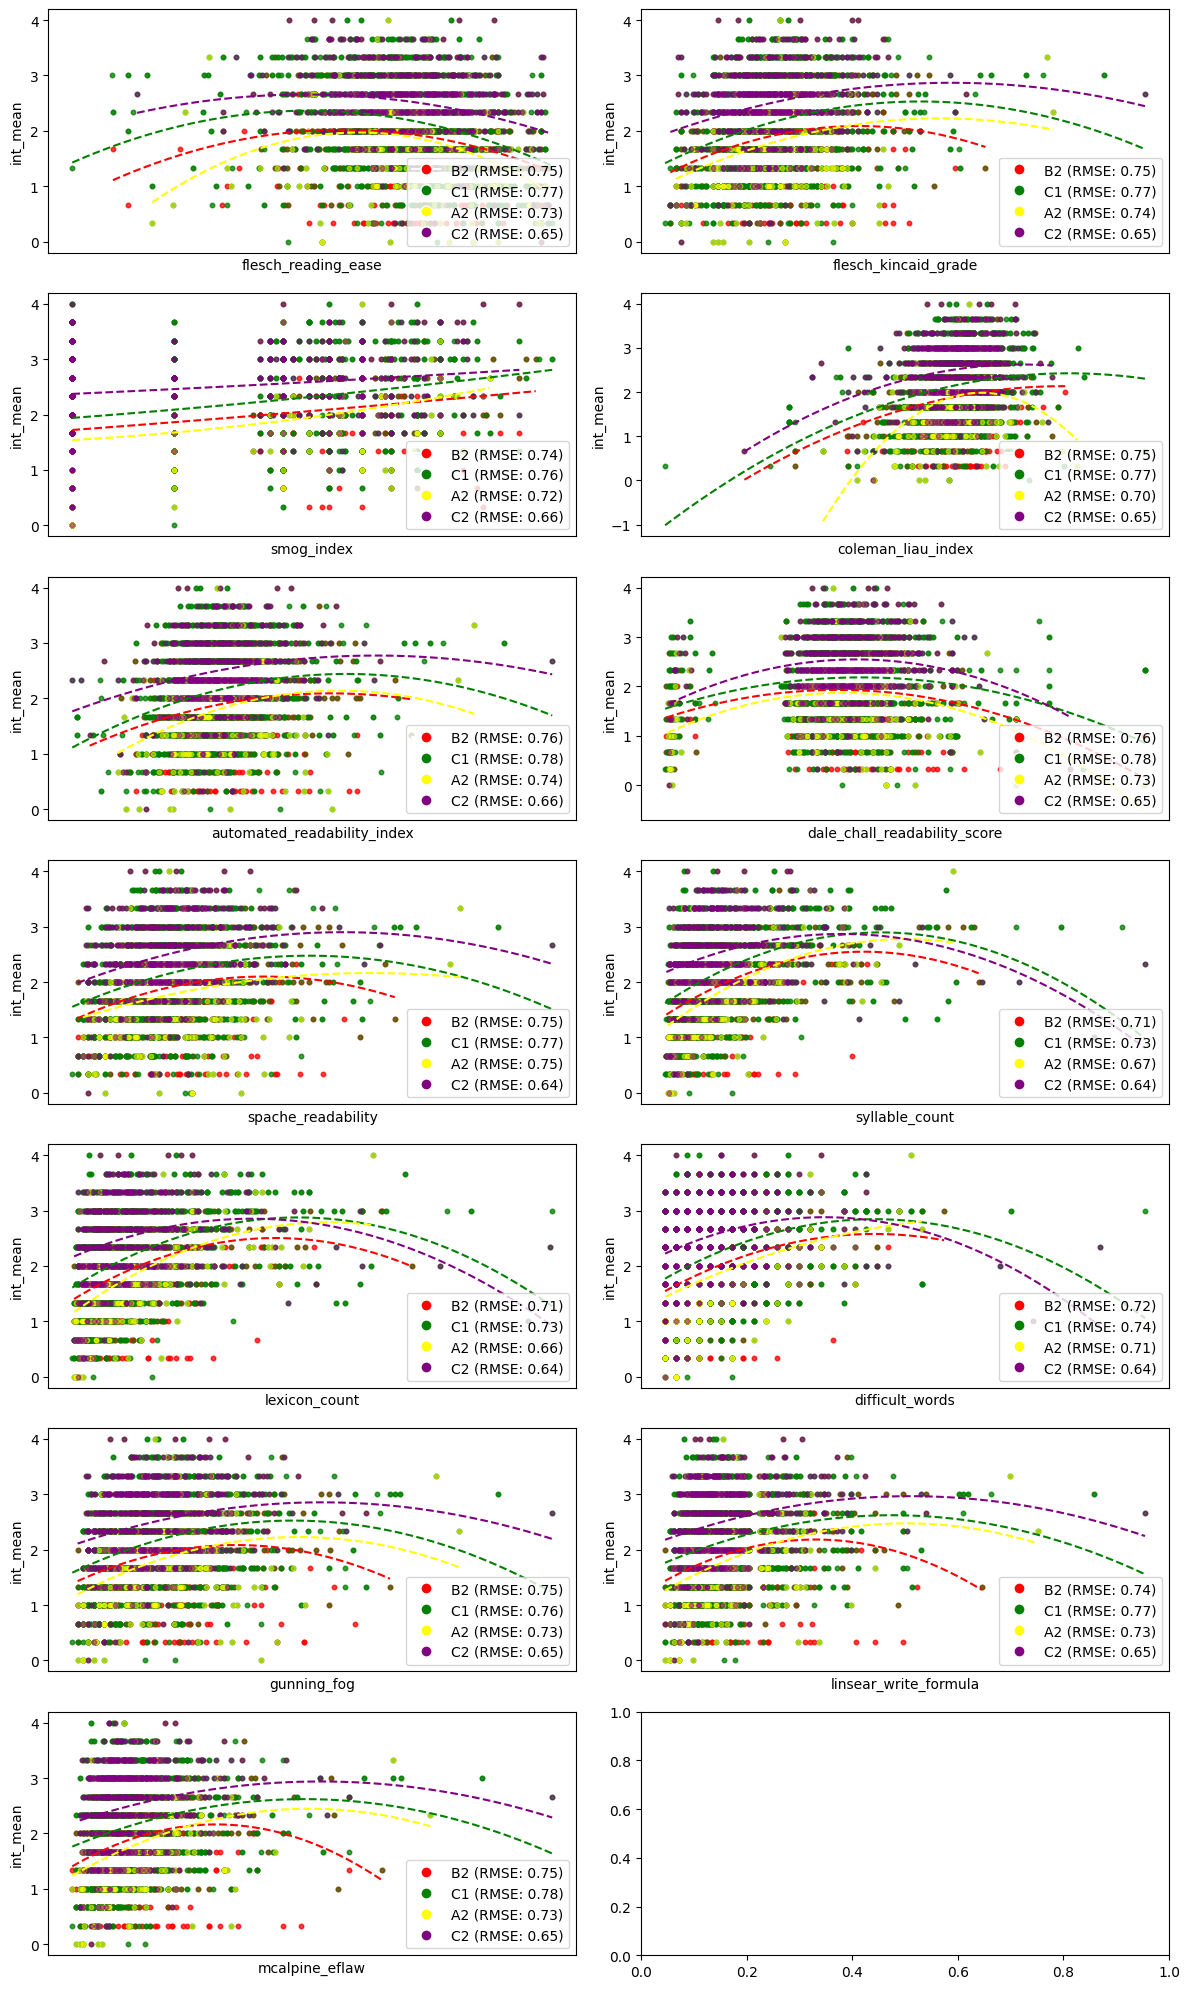

In [108]:
# Create a 7x2 grid of subplots (14 total subplots)
fig, axes = plt.subplots(7, 2, figsize=(12, 20))


merged_comp = merged_comp[merged_comp['annotator_level']!='Unknown']
# Get the frequency of 'int_mean' values for scaling scatterplot sizes
frequency = merged_comp['int_mean'].value_counts()

# Loop over the columns from 11 to 24 (adjust the column index range as per your dataset)
for i in range(7, 20):
    row = (i - 7) // 2  # Calculate the row index based on the subplot arrangement
    col = (i - 7) % 2  # Calculate the column index based on the subplot arrangement

    # Calculate the size of scatter points based on frequency
    scatter_sizes = merged_comp.groupby(['int_mean', merged_comp.columns[i]]).size().div(frequency).mul(100)
    legend_labels = [] 
    # Plot scatter plot for each 'level' category with different colors
    for level, color in zip(merged_comp['annotator_level'].unique(), ['red',  'green', 'yellow', 'purple']):
        subset = merged_comp[merged_comp['annotator_level'] == level]
        axes[row, col].scatter(subset.iloc[:, i], subset['int_mean'], s=10, alpha=0.5, label=level, color=color)

     # Fit a quadratic line
        x = subset.iloc[:, i]
        y = subset['int_mean']
        if len(x) > 1:  # Ensure there's enough data to fit
            coeffs = np.polyfit(x, y, 2)  # Fit quadratic polynomial
            quad_line = np.poly1d(coeffs)  # Create a polynomial function

            # Generate x values for the line
            x_line = np.linspace(x.min(), x.max(), 100)

            # Plot the quadratic line
            axes[row, col].plot(x_line, quad_line(x_line), color=color, linestyle='--')

            # Calculate RMSE
            y_pred = quad_line(x)
            rmse = np.sqrt(mean_squared_error(y, y_pred))

            # Accumulate legend labels with RMSE for each level
            legend_labels.append(f'{level} (RMSE: {rmse:.2f})')

    # Create custom handles for the legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=legend_label) 
               for color, legend_label in zip(['red',  'green', 'yellow', 'purple'], legend_labels)]

    # Set the legend with the custom handles and labels
    axes[row, col].legend(handles=handles, loc='lower right')
    
    axes[row, col].set_ylabel('int_mean')
    axes[row, col].set_xlabel(merged_comp.columns[i])
    axes[row, col].set_xticks([])

plt.tight_layout()
plt.show()
